In [515]:
from numpy import *
from PlotFuncs import *
from LabFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
from numpy import random
from scipy.integrate import cumtrapz
import cmocean
from tqdm import tqdm

def costh_T_samples(fcosth2,lat,T,nt=1000,ngen=1000):
    costh_X = 2*random.uniform(size=ngen)-1
    phi_X = 2*pi*random.uniform(size=ngen)
    t_vals = linspace(0,T,nt)
    c1t = zeros(shape=(ngen,nt))
    for i in range(0,nt):
        c1t[:,i] = fcosth2(t_vals[i],costh_X,phi_X,lat)

    c_av = trapz(c1t,t_vals)/T
    return c_av

ngen = 100000




costh_samples = costh_T_samples(costh2Z,55.0,1.0,ngen=ngen)
h,ce = histogram(costh_samples,100)
cc = (ce[1:]+ce[0:-1])/2
P_costh = h/sum(h)


In [559]:
sigma_N = 1.0
N_true = 0.0
P_X = 7.0

logL1 = lambda x : 0.5*((N_true - x[0] - P_X*x[1])**2/sigma_N**2) - log(P_costh[argmin(abs(cc-x[1]))]) + 0.5*((N_true - x[0])**2/sigma_N**2)
res1 = minimize(logL1,array([0.0,mean(costh_samples)]),bounds=((None,None),(0, 1)))
L1 = -logL1(res1.x)

logL2 = lambda x : 0.5*((N_true - x[0] - x[2]*x[1])**2/sigma_N**2) - log(P_costh[argmin(abs(cc-x[1]))]) + 0.5*((N_true - x[0])**2/sigma_N**2)
res2 = minimize(logL2,array([0.0,mean(costh_samples),P_X]),bounds=((None,None),(0, 1),(None,None)))
L2 = -logL2(res2.x)

q = 2*(L1-L2)
q

print(L1,L2,q)

-2.3066935210385906 -2.3066935210385897 -1.7763568394002505e-15


In [553]:
sigma_N = 1.0
N_true = 0.0
P_X = 2.3

logL1 = lambda x : 0.5*((N_true - x[0] - P_X)**2/sigma_N**2) + 0.5*((N_true - x[0])**2/sigma_N**2)
res1 = minimize(logL1,array([0.0]))
L1 = -logL1(res1.x)

logL2 = lambda x : 0.5*((N_true - x[0] - x[1])**2/sigma_N**2) + 0.5*((N_true - x[0])**2/sigma_N**2)
res2 = minimize(logL2,array([0.0,P_X]),bounds=((None,None),(None,None)))
L2 = -logL2(res2.x)

q = 2*(L1-L2)
q

print(L1,L2,q)

-1.3224999999999998 -1.2068804797942253e-13 -2.644999999999758


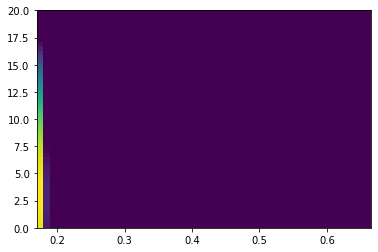

In [233]:
plt.pcolormesh(cc,Nvals,L.T-amax(L.T),vmin=-1,)

In [227]:
N_samples

array([-0.17539373])

In [118]:
from scipy.optimize import minimize

n_expts = 500
TS0 = zeros(shape=n_expts)
TS1 = zeros(shape=n_expts)

bnds1 = ((0, None), (0,None),(None, None))
bnds0 = ((0, None),)


P_true = 5.0
S_true = P_true*(1/3)
sigma_N = 1.0
N_true = 1.0
costh_samples = costh_T_samples(costh2Z,55.0,1.0,ngen=n_expts)
N_samples = random.normal(loc=N_true,scale=sigma_N,size=n_expts)
P_obs1 = P_true*costh_samples + N_samples
P_obs0 = N_samples

for expt in tqdm(range(0,n_expts)):
    logL1 = lambda x : 0.5*(P_obs1[expt]-x[0]*x[1]-x[2])**2/sigma_N**2 + 0.5*(N_true-x[2])**2/sigma_N**2 - log(P_costh[argmin(abs(cc-x[1]))])
    logL0 = lambda x : 0.5*(P_obs1[expt]-x[0])**2/sigma_N**2 + 0.5*(N_true-x[0])**2/sigma_N**2

    x1 = array([P_true,costh_samples[expt],N_samples[expt]])
    x0 = array([P_obs])
    res1 = minimize(logL1,x1,bounds=bnds1)
    res0 = minimize(logL0,x0)
    TS1[expt] = -2*(logL1(res1.x)-logL0(res0.x))
    
for expt in tqdm(range(0,n_expts)):
    logL1 = lambda x : 0.5*(P_obs0[expt]-x[0]*x[1]-x[2])**2/sigma_N**2 + 0.5*(N_true-x[2])**2/sigma_N**2 - log(P_costh[argmin(abs(cc-x[1]))])
    logL0 = lambda x : 0.5*(P_obs0[expt]-x[0])**2/sigma_N**2 + 0.5*(N_true-x[0])**2/sigma_N**2

    x1 = array([P_true,costh_samples[expt],N_samples[expt]])
    x0 = array([P_obs])
    res1 = minimize(logL1,x1,bounds=bnds1)
    res0 = minimize(logL0,x0)
    TS0[expt] = -2*(logL1(res1.x)-logL0(res0.x))

100%|██████████| 500/500 [00:21<00:00, 23.61it/s]


(array([184.,  89., 179.,  26.,   9.,   6.,   4.,   0.,   2.,   1.]),
 array([-8.21102877, -6.78897665, -5.36692453, -3.9448724 , -2.52282028,
        -1.10076816,  0.32128396,  1.74333609,  3.16538821,  4.58744033,
         6.00949245]),
 <a list of 10 Patch objects>)

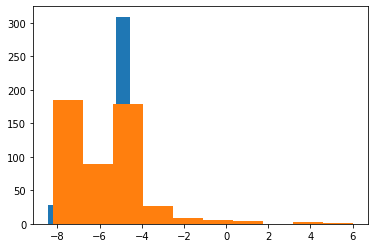

In [119]:
plt.hist(TS0)
plt.hist(TS1)

(array([  5.,  18.,  60., 103., 117., 102.,  49.,  32.,  11.,   3.]),
 array([-0.75890965, -0.00720063,  0.74450838,  1.4962174 ,  2.24792641,
         2.99963543,  3.75134444,  4.50305346,  5.25476248,  6.00647149,
         6.75818051]),
 <a list of 10 Patch objects>)

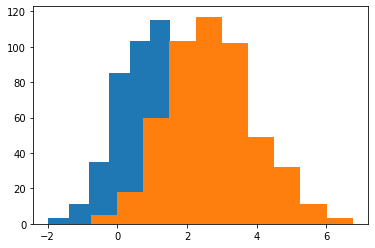

In [120]:
plt.hist(P_obs0)
plt.hist(P_obs1)

0.9325
0.8889


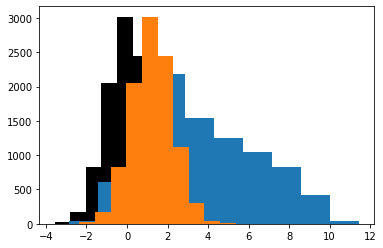

In [139]:
n_expts = 10000
P_true = 10.5
sigma_N = 1.0
N_true = 0.0
costh_samples = costh_T_samples(costh2Z,45.0,0.3,ngen=n_expts)
costh_95 = quantile(costh_samples,0.05)

N_samples = random.normal(loc=N_true,scale=sigma_N,size=n_expts)
P_obs1 = P_true*costh_samples + N_samples
P_obs2 = P_true*quantile(costh_samples,0.22) + N_samples
P_obs0 = N_samples
plt.hist(P_obs0,color='k')
plt.hist(P_obs1)

plt.hist(P_obs2)

print(sum(P_obs1>median(P_obs0))/n_expts)
print(sum(P_obs2>median(P_obs0))/n_expts)

In [97]:
median(costh_samples)

0.2669391070131927

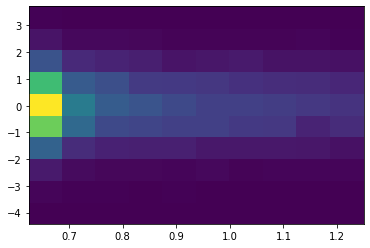

In [85]:
P = P_true*costh_samples
N = random.normal(loc=N_true,scale=sigma_N,size=n_expts)
plt.hist2d(P,N);

0.94981


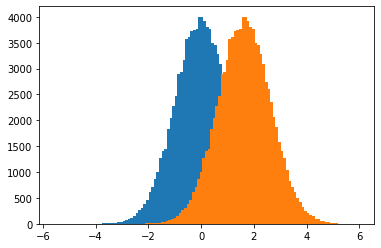

In [471]:
sigma_N = 1.0
P_true = 1.64
N_true = 0.0
N_samples = random.normal(loc=N_true,scale=sigma_N,size=n_expts)
P_obs0 = N_samples
P_obs1 = P_true + N_samples

plt.hist(P_obs0,100)
plt.hist(P_obs1,100)

print(sum(P_obs1>median(P_obs0))/n_expts)

In [660]:
n_expts = 100000
costh_samples = costh_T_samples(costh2Z,35.0,0.5,ngen=n_expts)

0.963


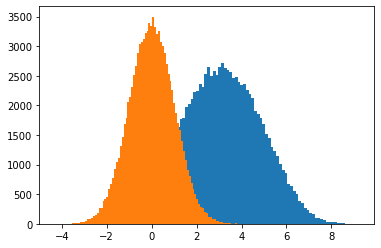

In [661]:
sigma_N = 1.0
P_true = 1.64/(quantile(costh_samples,0.18708))
N_true = 0.0
N_samples = random.normal(loc=N_true,scale=sigma_N,size=n_expts)
P_obs0 = N_samples
P_obs1 = P_true*costh_samples + N_samples

plt.hist(P_obs1,100)
plt.hist(P_obs0,100)

print(sum(P_obs1>0)/n_expts)

In [642]:
interp(0.95,Prob,P0_vals)

9.902620936141815

In [643]:
P_true

4.92

In [664]:
from scipy import stats

n =100

P0_vals = linspace(0,100,n)
Prob = zeros((n))
for i in range(0,n):
    h,ce = histogram(P0_vals[i]*costh_samples,nbins)
    cc = (ce[1:]+ce[0:-1])/2
    P_costh = h/sum(h)
    f = 0.5*(1+erf((-cc)/sqrt(2)))
    Prob[i] = 1-sum(f*P_costh)
    
P0_vals = linspace(0,100,n)
Prob_disc = zeros((n))
for i in range(0,n):
    h,ce = histogram(P0_vals[i]*costh_samples,nbins)
    cc = (ce[1:]+ce[0:-1])/2
    P_costh = h/sum(h)
    f = 0.5*(1+erf((3-cc)/sqrt(2)))
    Prob_disc[i] = 1-sum(f*P_costh)
    
PX_excl = interp(0.95,Prob,P0_vals)
PX_disc = interp(0.95,Prob_disc,P0_vals)
    
cval_excl = 1.64/PX_excl
cval_disc = (3+1.64)/PX_disc
print(cval_excl,cval_disc)

0.21435791455452619 0.1142602026855852


0.10012
0.2444


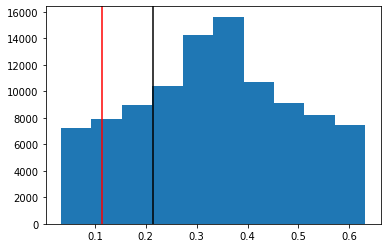

In [669]:
plt.hist(costh_samples)
plt.axvline(cval_disc,color='r')
plt.axvline(cval_excl,color='k')

print(stats.percentileofscore(costh_samples,cval_disc)/100)
print(stats.percentileofscore(costh_samples,cval_excl)/100)

In [438]:
from scipy import stats

def FindPercentile(costh_samples,nbins=100,n_expts=100000):
    h,ce = histogram(costh_samples,nbins)
    cc = (ce[1:]+ce[0:-1])/2
    P_costh = h/sum(h) 

    P0_vals = linspace(0,200,nbins)
    Prob = zeros((nbins))
    for i in range(0,nbins):
        f = 0.5*(1+erf(-P0_vals[i]*cc/sqrt(2)))
        Prob[i] = 1-sum(f*P_costh)


    cval = 1.64/interp(0.95,Prob,P0_vals)

    percentile = stats.percentileofscore(costh_samples,cval)/100
    return percentile,cval

nT = 50
Tvals = linspace(0.01,1.0,nT)
P = zeros((nT))
costhP = zeros((nT))
for i in tqdm(range(0,nT)):
    n_expts = 10000
    costh_samples = costh_T_samples(costh2Z,35.0,Tvals[i],ngen=n_expts)
    P[i],costhP[i] = FindPercentile(costh_samples)


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


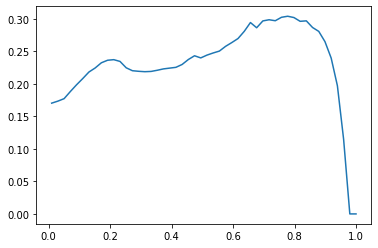

In [439]:
plt.plot(Tvals,P)

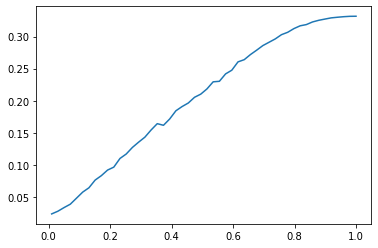

In [435]:
plt.plot(Tvals,costhP)

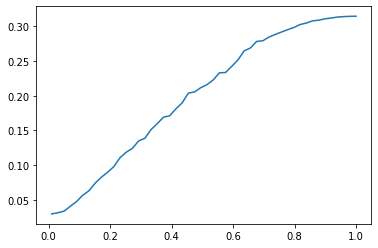

In [440]:
plt.plot(Tvals,costhP)